In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import sys
import os

# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import dem
from dem.models.components.mlp import MyMLP


from dem.energies.gmm_energy import GMM

/home/mila/b/bosejoey/scratch/micromamba/envs/dem/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:

from dem.models.components.sde_integration import integrate_ode
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import LinearNoiseSchedule
from dem.energies.base_prior import Prior
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.000004, sigma_max=0.4)
beta = torch.tensor(0.2).to(device)
noise_schedule = LinearNoiseSchedule(beta)
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

prior = Prior(dim=2, device=device, scale = noise_schedule.h(1) ** 0.5)

In [5]:
import abc

class Schedule_base(metaclass=abc.ABCMeta):
    """Abstract base class from which all log densities should inherit."""

    def __init__(self):
        pass

    def __call__(self, x):
        outf = self.tt(x)
        doutf = self.dtt(x)
        
        return outf, doutf

    @abc.abstractmethod
    def tt(self, x): 
        pass

    @abc.abstractmethod
    def dtt(self, x): 
        pass

class CosSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
    def tt(self,t):
        out = 0.5*(1.0-torch.cos(torch.pi*t))
        return out

    def dtt(self,t):
        out = (0.5*torch.pi*torch.sin(torch.pi*t))
        return out

class LinearSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def tt(self, t):
        out = t 
        return out

    def dtt(self, t):
        out = torch.tensor(1.0).to(self.device)
        return out

In [6]:
import torch
from torch.autograd.functional import jacobian
import abc

class ReverseODE(torch.nn.Module):
    def __init__(self, drift, noise_schedule, prior, target, clipper, schedule, resample_threshold=0.98):
        super().__init__()
        self.drift = drift
        self.noise_schedule = noise_schedule
        self.prior = prior
        self.target = target
        self.clipper = clipper
        self.schedule = schedule
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resample_threshold = resample_threshold
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            return self.drift(t, x)
        
    def divergence(self, t, x, vectorfield):
        # compute the divergence of the flow field
        def _func_sum(t_in, x_in):
            return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
        out= jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
        spatial_grad = out[1]
        div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
        return div
    
    def energy_interpolation(self, t, x):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            energy_interpolation = outf * logtarget + (1-outf) * logprior
            return energy_interpolation.squeeze()
        
    def log_weight_step(self, w, x, t, dt):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            partial_Ht = - (doutf * logtarget  - doutf * logprior)
           
            transport_div = self.divergence(t, x, self.drift)
            nabla_Ht = jacobian(self.energy_interpolation, (t, x),create_graph =True,vectorize=True)[1]
            nabla_Ht_div = nabla_Ht.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)

        term1 = (self.drift(t, x) * nabla_Ht_div[:, None]).sum(axis=1)
        
        # Equation in Algo 1 of NETS paper
        dw = (-partial_Ht - term1 + transport_div) * dt
        w = w + dw
        return w
    
    def resample(self, samples, weights):
        # Check if weights are blowing up (using effective sample size as a metric)
        # Calculate effective sample size
        ess = torch.exp(weights).sum()**2 / torch.exp(2 * weights).sum()
        ess_ratio = ess / weights.shape[0]
        
        # Only resample if effective sample size is above threshold (e.g., 0.5)
        # This prevents resampling when weights are degenerate
        if ess_ratio > self.resample_threshold:
            # Convert weights to probabilities (normalize)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8
            probs = torch.exp(weights) + epsilon
            probs = probs / probs.sum()
            
            # Perform importance sampling resampling
            # Sample indices based on weights
            num_samples = weights.shape[0]
            indices = torch.multinomial(probs, num_samples, replacement=True)
            
            # Resample the final particles based on the sampled indices
            resampled_samples = samples[indices]
            weights = torch.zeros_like(weights)
        else:
            resampled_samples = samples
            weights = weights

        return resampled_samples, weights
    
    def euler_step(self, t, x, dt):
        drift = self.f(t, x) * dt
        x = x + drift
        return x
    
    def sample(self, x0, dt, end_time, device=None, num_samples=None, compute_weight=False):
        """
        Sample from the ODE using Euler method.
        
        Args:
            x0: initial positions
            num_steps: number of integration steps
            dt: time step size
            device: device to run on
            
        Returns:
            samples: trajectory of samples
        """

        if device is None:
            device = x0.device
        
        if x0 is None:
            x = self.prior.sample(num_samples)
        else:
            x = x0

        samples = [x]
        w = torch.zeros(x.shape[0]).to(self.device)
        weights = [w]
        start_time = torch.tensor(0.0).to(self.device)
        delta = end_time - start_time
        num_integration_steps = int(torch.abs(delta) / dt)
        times = torch.linspace(start_time, end_time, num_integration_steps + 1, device=x.device)[:-1]
       
        for t in times:
            x = self.euler_step(t, x, dt)
            if compute_weight:
                w = self.log_weight_step(w, x, t, dt)
                x, w = self.resample(x, w)
                weights.append(w)

            samples.append(x)
        
        return torch.stack(samples)


class LangevinSDE(torch.nn.Module):
    """
    Langevin SDE implementation for sampling from energy functions.
    
    The Langevin SDE is given by:
    dx = -∇E(x)dt + √(2β) dW
    
    where E(x) is the energy function, β is the inverse temperature,
    and W is a Wiener process.
    """
    
    def __init__(self, beta=1.0, schedule=None, target=None, prior=None, vel=None, clipper=None, resample_threshold=0.98):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.beta = torch.tensor(beta).to(self.device)
        self.schedule = schedule
        self.target = target
        self.prior = prior
        self.vel = vel
        self.clipper = clipper
        self.resample_threshold = resample_threshold
    
    def f(self, t, x):
        """
        Drift term: f(t, x) = -∇E(x)
        
        Args:
            t: time (not used in Langevin dynamics)
            x: current position
            
        Returns:
            drift: -∇E(x)
        """
        
        with torch.enable_grad():
            outf, doutf = self.schedule(t)
            x.requires_grad_(True)
            energy_interpolation = outf * self.target(x) + (1-outf) * self.prior.log_prob(x)
            nabla_Ht = torch.autograd.grad(energy_interpolation.sum(), x, create_graph=True)[0]
            nabla_Ht = self.clipper.clip_scores(nabla_Ht)
            drift = nabla_Ht
            if self.vel is not None:    
                transport_drift = self.vel(t, x)
            else:
                transport_drift = torch.zeros_like(x)
        return drift + transport_drift
    
    def g(self, x):
        """
        Diffusion term: g(t, x) = √(2β)
        
        Args:
            t: time (not used in Langevin dynamics)
            x: current position
            
        Returns:
            diffusion: √(2β) * ones_like(x)
        """
        diffusion = torch.sqrt(2.0 * self.beta) * torch.ones_like(x)
        return diffusion
    
    def divergence(self, t, x, vectorfield):
        # compute the divergence of the flow field
        def _func_sum(t_in, x_in):
            return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
        out= jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
        spatial_grad = out[1]
        div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
        return div

    def euler_maruyama_step(self, t, x, dt):
        t = t * torch.ones(x.shape[0]).to(self.device)
        drift = self.f(t, x)
        diffusion = self.g(x)
        dW = torch.randn_like(x) * torch.sqrt(dt)
        x = x + drift * dt + diffusion * dW
        return x
    
    def energy_interpolation(self, t, x):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            energy_interpolation = outf * logtarget + (1-outf) * logprior
            return energy_interpolation.squeeze()
        
    def log_weight_step(self, w, x, t, dt):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            partial_Ht = - (doutf * logtarget  - doutf * logprior)
           
            transport_div = self.divergence(t, x, self.vel)
            nabla_Ht = jacobian(self.energy_interpolation, (t, x),create_graph =True,vectorize=True)[1]
            nabla_Ht_div = nabla_Ht.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)

        term1 = (self.vel(t, x) * nabla_Ht_div[:, None]).sum(axis=1)
        
        # Equation in Algo 1 of NETS paper
        dw = (-partial_Ht - term1 + transport_div) * dt
        w = w + dw
        return w
    
    def resample(self, samples, weights):
        # Check if weights are blowing up (using effective sample size as a metric)
        # Calculate effective sample size
        ess = torch.exp(weights).sum()**2 / torch.exp(2 * weights).sum()
        ess_ratio = ess / weights.shape[0]
        
        # Only resample if effective sample size is above threshold (e.g., 0.5)
        # This prevents resampling when weights are degenerate
        if ess_ratio > self.resample_threshold:
            # Convert weights to probabilities (normalize)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8
            probs = torch.exp(weights) + epsilon
            probs = probs / probs.sum()
            
            # Perform importance sampling resampling
            # Sample indices based on weights
            num_samples = weights.shape[0]
            indices = torch.multinomial(probs, num_samples, replacement=True)
            
            # Resample the final particles based on the sampled indices
            resampled_samples = samples[indices]
            weights = torch.zeros_like(weights)
        else:
            resampled_samples = samples
            weights = weights

        return resampled_samples, weights
    
    def sample(self, x0, dt, end_time, device=None, num_samples=None, compute_weight=False):
        """
        Sample from the Langevin SDE using Euler-Maruyama method.
        
        Args:
            x0: initial positions
            num_steps: number of integration steps
            dt: time step size
            device: device to run on
            
        Returns:
            samples: trajectory of samples
        """

        if device is None:
            device = x0.device
        
        if x0 is None:
            x = self.prior.sample(num_samples)
        else:
            x = x0

        samples = [x]
        w = torch.zeros(x.shape[0]).to(self.device)
        weights = [w]
        start_time = torch.tensor(0.0).to(self.device)
        delta = end_time - start_time
        num_integration_steps = int(torch.abs(delta) / dt)
        times = torch.linspace(start_time, end_time, num_integration_steps + 1, device=x.device)[:-1]
       
        for t in times:
            x = self.euler_maruyama_step(t, x, dt)
            if compute_weight:
                w = self.log_weight_step(w, x, t, dt)
                x, w = self.resample(x, w)
                weights.append(w)

            samples.append(x)
        
        return torch.stack(samples)

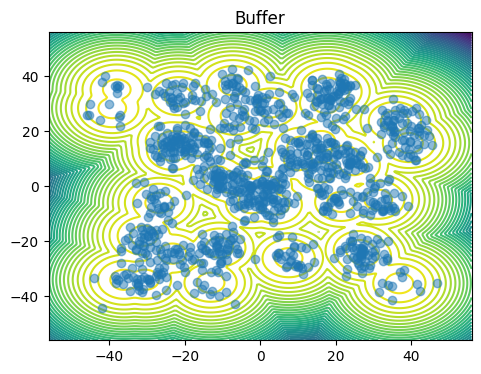

In [7]:
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)

vectorfield = MyMLP().to(device)
optimizer = Adam(vectorfield.parameters(), lr=1e-3)
weighted = False
schedule = LinearSchedule()
langevin_sde = LangevinSDE(beta=1.0, prior=prior, target=target, clipper=clipper, schedule=schedule)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
samples = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_000, compute_weight=False)
samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()


In [8]:
def divergence(t, x, vectorfield):
    # compute the divergence of the flow field
    def _func_sum(t_in, x_in):
        return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
    out=jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
    spatial_grad = out[1]
    div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
    return div

def compute_pf_loss(x, t, schedule, target, prior, vectorfield):    
    outf, doutf = schedule(t)
    x.requires_grad_(True)
    logtarget = target(x)
    dlogtarget = torch.autograd.grad(logtarget.sum(), x, create_graph=True)[0]
    logprior = prior.log_prob(x)
    dlogprior = torch.autograd.grad(logprior.sum(), x, create_graph=True)[0]
    score = outf * dlogtarget + (1-outf) * dlogprior
    score = clipper.clip_scores(score)  

    t_repeat = t.repeat(x.shape[0], 1)
    vel = vectorfield(t_repeat, x)
    div = divergence(t_repeat, x, vectorfield)
    inner_prod = (score*vel).sum(axis=1)

    term1 = (inner_prod - div).pow(2)
    partial_Ht = - (doutf * logtarget  - doutf * logprior)
    nabla_partial_Ht = torch.autograd.grad(partial_Ht.sum(), x, create_graph=True)[0]
    
    term2 = 2* (nabla_partial_Ht.squeeze() * vel).sum(axis=1)

    loss = (term1 + term2)

    return loss

def generate_samples_ode(reverse_ode, num_samples):
    x = prior.sample(num_samples)
    delta = t_end - t_init
    num_integration_steps = int(torch.abs(delta) / dt)
    times = torch.linspace(t_init, t_end, num_integration_steps + 1, device=device)[:-1]
    for t in times:
        drift = reverse_ode.f(t, x) * dt
        x = x + drift
    return x

In [ ]:
epsilon = 1e-6
reverse_ode = ReverseODE(vectorfield, noise_schedule, prior=prior, target=target, clipper=clipper, schedule=schedule)
num_samples = 1_024
outer_epochs = 100
inner_epochs = 2
beta = 1.0

for epoch in tqdm(range(outer_epochs)):
    target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)

    total_loss = 0.
    start_time = torch.tensor(0.0).to(device)
    delta = t_end - start_time
    num_integration_steps = int(torch.abs(delta) / dt)
    times = torch.linspace(start_time, t_end, num_integration_steps + 1)[:-1]
    indices = torch.arange(times.shape[0]).to(device)
    langevin_sde = LangevinSDE(beta=beta, prior=prior, target=target, vel=vectorfield, clipper=clipper, schedule=schedule)
    x_gen = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_024, compute_weight=False).detach()
    
    for i, t in zip(indices, times):
        for j in range(inner_epochs):
            if j % 2 == 0:
                x_gen = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_024, compute_weight=False)
            else:
                x_gen = x_gen.to(device).detach()
            
            optimizer.zero_grad()
            x = x_gen[i].to(device).detach()
            t = t.to(device).detach()
            loss = compute_pf_loss(x, t, schedule, target, prior, vectorfield)
            loss = loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if j % 9 == 0:
                print("Epoch %d | Inner Epoch %d | Time %f | Loss %f" % (epoch, j, t.item(), loss.item()))
            # print("Epoch %d | Time %f | Loss %f" % (epoch, t.item(), loss.item()))

    # Generate samples using the network
    samples = generate_samples_ode(reverse_ode, 1_024)
    samples_energy = target(samples)
    target.get_dataset_fig(target.unnormalize(samples))
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Inner Epoch 0 | Time 0.000000 | Loss 6.422470
Epoch 0 | Inner Epoch 0 | Time 0.001953 | Loss -67.447891
Epoch 0 | Inner Epoch 0 | Time 0.003906 | Loss -6.694935
Epoch 0 | Inner Epoch 0 | Time 0.005859 | Loss -79.984039
Epoch 0 | Inner Epoch 0 | Time 0.007812 | Loss -127.717964
Epoch 0 | Inner Epoch 0 | Time 0.009766 | Loss -118.058365
Epoch 0 | Inner Epoch 0 | Time 0.011719 | Loss -103.401566
Epoch 0 | Inner Epoch 0 | Time 0.013672 | Loss -91.808105
Epoch 0 | Inner Epoch 0 | Time 0.015625 | Loss -81.228447
Epoch 0 | Inner Epoch 0 | Time 0.017578 | Loss -50.658966
Epoch 0 | Inner Epoch 0 | Time 0.019531 | Loss -83.350189
Epoch 0 | Inner Epoch 0 | Time 0.021484 | Loss -73.963684
Epoch 0 | Inner Epoch 0 | Time 0.023438 | Loss -63.006691
Epoch 0 | Inner Epoch 0 | Time 0.025391 | Loss -60.956249
Epoch 0 | Inner Epoch 0 | Time 0.027344 | Loss -58.957657
Epoch 0 | Inner Epoch 0 | Time 0.029297 | Loss -59.560326
Epoch 0 | Inner Epoch 0 | Time 0.031250 | Loss -45.885719
Epoch 0 | Inne

In [ ]:
target = GMM(dimensionality=2,
            n_mixes=40,
            loc_scaling= 40,
            log_var_scaling=1.0,
            device=device,
            should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule, prior=prior, target=target, clipper=clipper, schedule=schedule, resample_threshold=0.98)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
# samples = reverse_ode.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_000, compute_weight=False)[-1]
samples = generate_samples_ode(reverse_ode, 1_024)
samples_energy = target(samples)
target.get_dataset_fig(target.unnormalize(samples))
plt.show()

In [ ]:
target = GMM(dimensionality=2,
            n_mixes=40,
            loc_scaling= 40,
            log_var_scaling=1.0,
            device=device,
            should_unnormalize=True)
langevin_sde = LangevinSDE(beta=beta, prior=prior, target=target, clipper=clipper, vel=vectorfield, schedule=schedule)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
samples = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=5_000, compute_weight=True)
samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()